<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="45%" align="right" border="4">

# Multi-Risk Derivatives Portfolios

The step from multi-risk derivatives instruments to multi-risk derivatives instrument portfolios is not a too large one. This part of the tutorial shows how to model an economy with three risk factors

In [1]:
from dx import *
from pylab import plt
plt.style.use('seaborn-v0_8')

## Risk Factors

This sub-section models the single risk factors. We start with definition of the risk-neutral discounting object.

In [2]:
# constant short rate
r = constant_short_rate('r', 0.02)

**Three risk factors** ares modeled:

* geometric Brownian motion
* jump diffusion
* stochastic volatility process

In [3]:
# market environments
me_gbm = market_environment('gbm', dt.datetime(2015, 1, 1))
me_jd = market_environment('jd', dt.datetime(2015, 1, 1))
me_sv = market_environment('sv', dt.datetime(2015, 1, 1))

Assumptions for the `geometric_brownian_motion` object.

In [4]:
# geometric Brownian motion
me_gbm.add_constant('initial_value', 36.)
me_gbm.add_constant('volatility', 0.2) 
me_gbm.add_constant('currency', 'EUR')
me_gbm.add_constant('model', 'gbm')

Assumptions for the `jump_diffusion` object.

In [5]:
# jump diffusion
me_jd.add_constant('initial_value', 36.)
me_jd.add_constant('volatility', 0.2)
me_jd.add_constant('lambda', 0.5)
    # probability for jump p.a.
me_jd.add_constant('mu', -0.75)
    # expected jump size [%]
me_jd.add_constant('delta', 0.1)
    # volatility of jump
me_jd.add_constant('currency', 'EUR')
me_jd.add_constant('model', 'jd')

Assumptions for the `stochastic_volatility` object.

In [6]:
# stochastic volatility model
me_sv.add_constant('initial_value', 36.)
me_sv.add_constant('volatility', 0.2)
me_sv.add_constant('vol_vol', 0.1)
me_sv.add_constant('kappa', 2.5)
me_sv.add_constant('theta', 0.4)
me_sv.add_constant('rho', -0.5)
me_sv.add_constant('currency', 'EUR')
me_sv.add_constant('model', 'sv')

Finally, the unifying valuation assumption for the **valuation environment**.

In [7]:
# valuation environment
val_env = market_environment('val_env', dt.datetime(2015, 1, 1))
val_env.add_constant('paths', 10000)
val_env.add_constant('frequency', 'W')
val_env.add_curve('discount_curve', r)
val_env.add_constant('starting_date', dt.datetime(2015, 1, 1))
val_env.add_constant('final_date', dt.datetime(2015, 12, 31))

These are added to the single `market_environment` objects of the risk factors.

In [8]:
# add valuation environment to market environments
me_gbm.add_environment(val_env)
me_jd.add_environment(val_env)
me_sv.add_environment(val_env)

Finally, the **market model** with the risk factors and the correlations between them.

In [9]:
risk_factors = {'gbm' : me_gbm, 'jd' : me_jd, 'sv' : me_sv}
correlations = [['gbm', 'jd', 0.66], ['jd', 'sv', -0.75]]

## Derivatives

In this sub-section, we model the single derivatives instruments.

### American Put Option

The first derivative instrument is an **American put option**.

In [10]:
gbm = geometric_brownian_motion('gbm_obj', me_gbm)

In [11]:
me_put = market_environment('put', dt.datetime(2015, 1, 1))
me_put.add_constant('maturity', dt.datetime(2015, 12, 31))
me_put.add_constant('strike', 40.)
me_put.add_constant('currency', 'EUR')
me_put.add_environment(val_env)

In [12]:
am_put = valuation_mcs_american_single('am_put', mar_env=me_put, underlying=gbm,
                       payoff_func='np.maximum(strike - instrument_values, 0)')

In [13]:
am_put.present_value(fixed_seed=True, bf=5)

np.float64(5.012)

### European Maximum Call on 2 Assets

The second derivative instrument is a **European maximum call option on two risk factors**.

In [14]:
jd = jump_diffusion('jd_obj', me_jd)

In [15]:
me_max_call = market_environment('put', dt.datetime(2015, 1, 1))
me_max_call.add_constant('maturity', dt.datetime(2015, 9, 15))
me_max_call.add_constant('currency', 'EUR')
me_max_call.add_environment(val_env)

In [16]:
payoff_call = "np.maximum(np.maximum(maturity_value['gbm'], maturity_value['jd']) - 34., 0)"

In [17]:
assets = {'gbm' : me_gbm, 'jd' : me_jd}
asset_corr = [correlations[0]]

In [18]:
asset_corr

[['gbm', 'jd', 0.66]]

In [19]:
max_call = valuation_mcs_european_multi('max_call', me_max_call, assets, asset_corr,
        payoff_func=payoff_call)

In [20]:
max_call.present_value(fixed_seed=False)

np.float64(8.334)

In [21]:
max_call.delta('jd')

np.float64(0.7596)

In [22]:
max_call.delta('gbm')

np.float64(0.2824)

### American Minimum Put on 2 Assets

The third derivative instrument is an **American minimum put on two risk factors**.

In [23]:
sv = stochastic_volatility('sv_obj', me_sv)

In [24]:
me_min_put = market_environment('min_put', dt.datetime(2015, 1, 1))
me_min_put.add_constant('maturity', dt.datetime(2015, 6, 17))
me_min_put.add_constant('currency', 'EUR')
me_min_put.add_environment(val_env)

In [25]:
payoff_put = "np.maximum(32. - np.minimum(instrument_values['jd'], instrument_values['sv']), 0)"

In [26]:
assets = {'jd' : me_jd, 'sv' : me_sv}
asset_corr = [correlations[1]]
asset_corr

[['jd', 'sv', -0.75]]

In [27]:
min_put = valuation_mcs_american_multi(
                'min_put', val_env=me_min_put, risk_factors=assets,
                correlations=asset_corr, payoff_func=payoff_put)

In [28]:
min_put.present_value(fixed_seed=True)

np.float64(4.301)

In [29]:
min_put.delta('jd')

np.float64(-0.107)

In [30]:
min_put.delta('sv')

np.float64(-0.2199)

## Portfolio

To compose a derivatives portfolio, `derivatives_position` objects are needed.

In [31]:
am_put_pos = derivatives_position(
                    name='am_put_pos',
                    quantity=2,
                    underlyings=['gbm'],
                    mar_env=me_put,
                    otype='American single',
                    payoff_func='np.maximum(instrument_values - 36., 0)')

In [32]:
max_call_pos = derivatives_position(
                    'max_call_pos', 3, ['gbm', 'jd'],
                    me_max_call, 'European multi',
                    payoff_call)

In [33]:
min_put_pos = derivatives_position(
                    'min_put_pos', 5, ['sv', 'jd'],
                    me_min_put, 'American multi',
                    payoff_put)

These objects are to be collected in `dictionary` objects.

In [34]:
positions = {'am_put_pos' : am_put_pos, 'max_call_pos' : max_call_pos,
             'min_put_pos' : min_put_pos}

All is together to instantiate the `derivatives_portfolio` class.

In [35]:
port = derivatives_portfolio(name='portfolio',
                             positions=positions,
                             val_env=val_env,
                             risk_factors=risk_factors,
                             correlations=correlations)

Let us have a look at the major **portfolio statistics**.

In [36]:
%time stats = port.get_statistics()

   pos_value                                          pos_delta  \
0      6.364                                             1.2184   
1     24.495  {'gbm': np.float64(0.8646), 'jd': np.float64(2...   
2     20.900  {'sv': np.float64(-1.179), 'jd': np.float64(-0...   

                                            pos_vega  
0                                            30.5422  
1  {'gbm': np.float64(14.9805), 'jd': np.float64(...  
2  {'sv': np.float64(10.1075), 'jd': np.float64(1...  
CPU times: user 737 ms, sys: 408 ms, total: 1.15 s
Wall time: 1.02 s


In [37]:
stats

,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,am_put_pos,am_put_pos,2,American single,[gbm],3.182,EUR,6.364,1.2184,30.5422
1,max_call_pos,max_call_pos,3,European multi,"[gbm, jd]",8.165,EUR,24.495,"{'gbm': np.float64(0.8646), 'jd': np.float64(2...","{'gbm': np.float64(14.9805), 'jd': np.float64(..."
2,min_put_pos,min_put_pos,5,American multi,"[sv, jd]",4.180,EUR,20.900,"{'sv': np.float64(-1.179), 'jd': np.float64(-0...","{'sv': np.float64(10.1075), 'jd': np.float64(1..."


In [38]:
stats['pos_value'].sum()

np.float64(51.759)

Finally, a graphical look at **two selected, simulated paths** of the stochastic volatility risk factor and the jump diffusion risk factor, respectively.

In [39]:
path_no = 1
paths1 = port.underlying_objects['sv'].get_instrument_values()[:, path_no]
paths2 = port.underlying_objects['jd'].get_instrument_values()[:, path_no]

In [40]:
paths1

array([36.        , 36.34884124, 34.9130166 , 36.31001777, 34.85894675,
       35.63213975, 39.0707393 , 44.35899961, 44.47413556, 43.13168786,
       47.48647475, 46.27393881, 43.49655379, 47.23009583, 49.53908109,
       43.71731937, 51.76008829, 52.58524036, 54.2573447 , 51.6460015 ,
       44.28088435, 39.01540236, 32.91109921, 30.24790867, 29.61667412,
       31.76473582, 27.30258542, 28.39127869, 28.23333544, 27.08972766,
       27.32993764, 28.65926992, 26.9785575 , 31.8938528 , 34.58971037,
       32.7699367 , 29.35365969, 28.66856698, 31.14196767, 31.37051847,
       30.10832392, 33.11928276, 34.48108709, 32.97416103, 28.08648082,
       26.52705819, 21.57771857, 20.42912064, 20.99231801, 19.23163105,
       21.37234395, 20.80944619, 20.73301676, 20.79953889, 20.34822548,
       18.69820953])

In [41]:
paths2

array([36.        , 36.09036184, 37.30618631, 36.53472814, 36.79572901,
       36.66944957, 35.56227649, 33.3644349 , 33.42674479, 34.22659123,
       32.22562864, 33.05209641, 33.82798732, 33.20431052, 33.78753542,
       36.17164509, 33.76072474, 33.00278459, 32.79744011, 33.50195594,
       34.40874205, 34.57037634, 37.00098086, 37.7309694 , 38.32223737,
       38.2477447 , 39.92233666, 39.6591103 , 39.43998269, 39.88306801,
       40.35338195, 40.23418088, 41.48106905, 39.66194269, 39.32622142,
       39.48978055, 40.67396363, 40.76122376, 40.00499204, 39.725126  ,
       40.05448393, 39.06546207, 37.674332  , 38.48264394, 40.86222422,
       41.3749628 , 44.02458974, 45.32751049, 44.704871  , 45.06224883,
       43.38741804, 43.68855748, 44.75023229, 45.4285521 , 45.27511078,
       45.68070094])

The resulting plot illustrates the strong **negative correlation**.

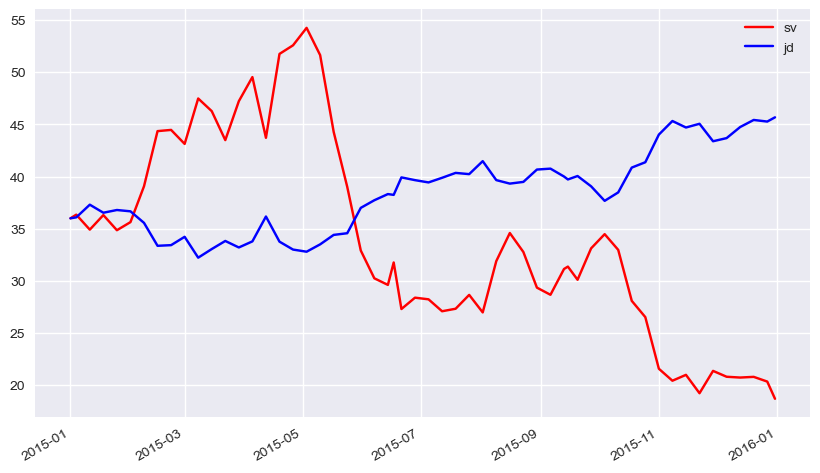

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 6))
plt.plot(port.time_grid, paths1, 'r', label='sv')
plt.plot(port.time_grid, paths2, 'b', label='jd')
plt.gcf().autofmt_xdate()
plt.legend(loc=0); plt.grid(True)
# negatively correlated underlyings

**Copyright, License & Disclaimer**

© Dr. Yves J. Hilpisch | The Python Quants GmbH

DX Analytics (the "dx library" or "dx package") is licensed under the GNU Affero General
Public License version 3 or later (see http://www.gnu.org/licenses/).

DX Analytics comes with no representations or warranties, to the extent
permitted by applicable law.

[Learn More & Stay in Touch](https://linktr.ee/dyjh)

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>